### Auto Encoder

- Reducing the Dimensionality of Data with Neural Networks 논문에서 제안 된 기법입니다.
- 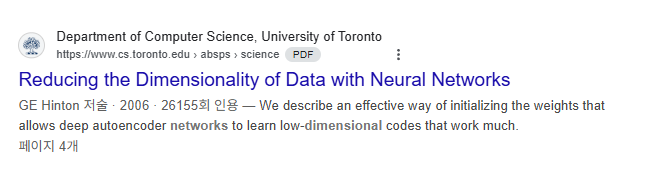
- 입력이 들어왔을 때 입력을 더 작은 차원의 벡터로 압축 한 뒤,
- 압축된 입력으로부터 원본을 다시 복구하는 학습을 합니다.
- 이 과정에서 데이터를 압축하는 Layer를 `Encoder`
- 데이터를 복구하는 Layer를 `Decoder` 라고 합니다.
- Auto Encoder는 이 학습을 통해 `Encoder` 가 `Latent Vector (잠재 벡터)` 를 찾습니다.
- `Latent Vector` 란 `특징만 추출된 벡터`를 의미한다 라고 보시면 됩니다.
- decoder는 `Latent Vector` 를 잘 찾았는지 검사하는 용도로 사용됩니다.
- Decoder는 “Latent Vector가 정말로 충분한 정보를 담고 있는지”를 검사하는 역할을 합니다.
  - (잘 압축되었다면 잘 복원될 것이고, 못 압축했다면 복원이 엉망일 것입니다.)

- 결국 Encoder는 불필요한 잡음(noise)을 버리고 중요한 특징만 남기는 방법을 배우게 됩니다.

- 특징을 추출하여 다시 복구했을 때, 특징이 잘 추출되었다면 복구가 잘 될것이라고 가정한 것입니다.
- 이거 말고 정답을 줄 방법도 따로 없기 때문에 자기 자신을 정답으로 쓰면서, 학습을 진행합니다.
- 우리가 직접 정답을 주지 않아도 되기 때문에 `비 지도 학습` 에 들어갑니다.
- 이러한 학습 과정을 거치면서, Encoder 는 이미지의 잡음은 제거하고, 특성을 추출하는 방법을 배웁니다.

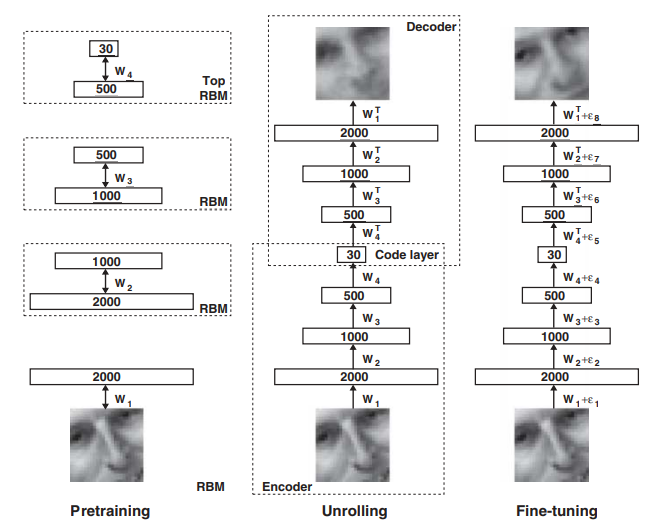

`pretraining`, `finetuning` 은 따로 진행하지 않고, 일반적인 복구 학습 만 진행합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# cuda 가 존재하면 gpu 를 사용하고, 그렇지 않다면 cpu 를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.ToTensor()

# MNIST Dataset을 다운로드 받습니다.
# 해당 경로에 이미 있으면 다운로드 받지 않습니다.
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

# 데이터셋을 받아옵니다.
# 이 때 모든 데이터를 한번에 학습 할 수 없기 때문에 128개씩 뽑아와서 학습 합니다.
# shuffle 옵션을 넣으면 데이터를 순서대로 넣는게 아니라 섞어서 넣습니다.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Using device: cuda


In [ ]:
# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        '''
            데이터를 압축
        '''
        # nn.Sequential 안에 들어있으면, 안에 들어있는 nn layer 들을 연속적으로 사용합니다.
        self.encoder = nn.Sequential(
            # 학습 데이터로, MNIST를 사용합니다.
            # MNIST 는 28 * 28 (784) 개의 픽셀로 이루어져 있습니다.
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            # 최종 Latent Vector 는 3차원 Vector 로 압축
            nn.Linear(12, 3)
        )
        '''
            데이터를 복구
            복구 과정은 압축과정과 같을 필요는 없지만. 그냥 같게 만들었습니다.
        '''
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            # 여기서 원본 복구
            nn.Linear(128, 28*28),
            nn.Sigmoid()   # 출력 데이터를 0과 1 사이로 스케일링
        )

    def forward(self, x):
        # x: (batch, 1, 28, 28) 라고 가정
        x = x.view(x.size(0), -1) 
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # 
    def encode(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

In [ ]:
def show_reconstruction(model):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images[:10].to(device)  # 앞에서 10개만

    with torch.no_grad():
        outputs = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    plt.figure(figsize=(15, 4))

    for i in range(10):
        # original
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")

        # reconstructed
        plt.subplot(2, 10, 10 + i + 1)
        plt.imshow(outputs[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.suptitle("Top: Original Images  |  Bottom: Reconstructed Images")
    plt.show()

show_reconstruction(model)